In [8]:
import numpy as np
import pandas as pd

from ase.io import read, write

from pyace import *
from pyace.activelearning import compute_B_projections

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

## read databases, original (2020) and the new data (2025)

In [6]:
# 1. Load the DataFrame from the pickle
df_2020 = pd.read_pickle("../ACE2020_potential/Database/W.pckl.gzip", compression="gzip")
df_2025 = pd.read_pickle("../ACE2025_potential/Database/W_2025.pckl.gzip", compression="gzip")

configs_2020 = []
configs_2025 = []

# 2. Loop over all rows and attach energy & forces to the Atoms objects
for idx, row in df_2020.iterrows():
    at = row["ase_atoms"].copy()       # Atoms object
    energy = float(row["energy"])      # scalar energy
    forces = np.asarray(row["forces"], dtype=float)  # (N, 3)

    # Optional sanity check
    if forces.shape != (len(at), 3):
        raise ValueError(
            f"Force shape mismatch in frame {idx}: {forces.shape} vs natoms={len(at)}"
        )

    # Extended XYZ convention:
    # - per-frame scalars go in at.info
    # - per-atom arrays go in at.arrays
    at.info["energy"] = energy
    at.arrays["force"] = forces  # ASE will write this as "force:R:3"

    configs_2020.append(at)

for idx, row in df_2025.iterrows():
    at = row["ase_atoms"].copy()       # Atoms object
    energy = float(row["energy"])      # scalar energy
    forces = np.asarray(row["forces"], dtype=float)  # (N, 3)

    # Optional sanity check
    if forces.shape != (len(at), 3):
        raise ValueError(
            f"Force shape mismatch in frame {idx}: {forces.shape} vs natoms={len(at)}"
        )

    # Extended XYZ convention:
    # - per-frame scalars go in at.info
    # - per-atom arrays go in at.arrays
    at.info["energy"] = energy
    at.arrays["force"] = forces  # ASE will write this as "force:R:3"

    configs_2025.append(at)

In [13]:
W_bbasis_set = create_multispecies_basis_config(
    {
    'deltaSplineBins': 0.001,
    'elements': ['W'],

    'embeddings': {'ALL': {'drho_core_cut': 250,
                           'fs_parameters': [ 1, 1, 1, 0.5, 1, 0.75, 1, 0.25, 1, 0.125, 1, 0.375, 1, 0.875, 1, 2],
                           'ndensity': 8,
                           'npot': 'FinnisSinclairShiftedScaled',
                           'rho_core_cut': 200000}
                   },

    'bonds': {'ALL': {'NameOfCutoffFunction': 'cos',
                      'core-repulsion': [10000.0, 5.0],
                      'dcut': 0.01,
                      'radbase': 'SBessel',
                      'radparameters': [5.25],
                      'rcut': 7.8}
              },

    'functions': {        
        # different number of unary functions for Al and H
        'UNARY': {
            'nradmax_by_orders': [15, 4, 3, 1],
            'lmax_by_orders':    [0, 4, 3, 0]
        },
    }
})

def get_bbasis(asedata, bbasis_set):
    ''' 
    asedata: the structure dataset in ase type
    bbasis_set: 
    
    '''
    for i, structure in enumerate(asedata):    
        projections = compute_B_projections(bbasis_set,
                                            atomic_env_list=[structure])
        if i == 0:
            bbasis = projections[0]
        else:
            bbasis = np.append(bbasis,projections[0],axis=0)

    return bbasis

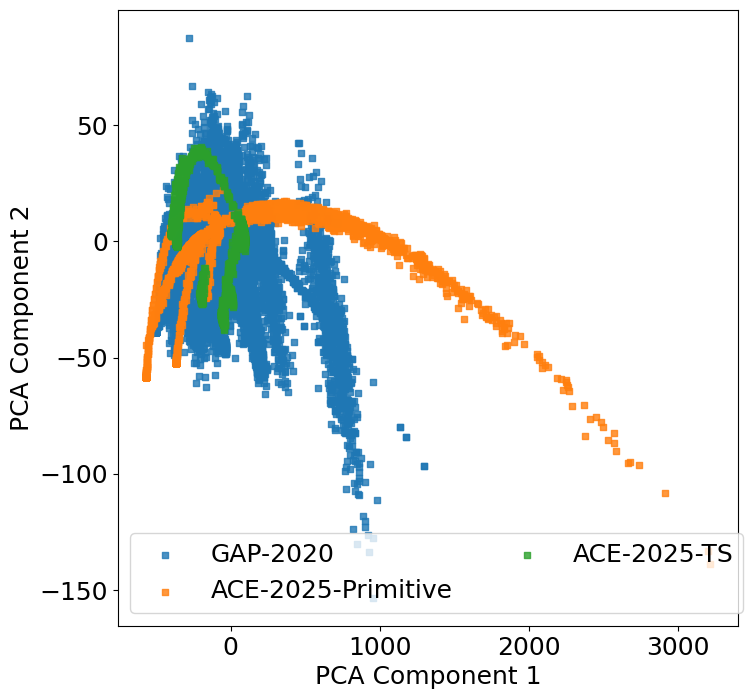

In [14]:

DB_2020 = get_bbasis(configs_2020, W_bbasis_set)
DB_2025_primitive = get_bbasis(configs_2025[3927:6980], W_bbasis_set)
DB_2025_ts = get_bbasis(configs_2025[6980:], W_bbasis_set)

# 2D Visualization of PCA result
fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 18})
ax = fig.add_subplot()

pca = PCA(n_components=2)

# Plot the data in 2D space
db1_label = ['GAP-2020', 'ACE-2025-Primitive', 'ACE-2025-TS']

for i, db1 in enumerate([DB_2020, DB_2025_primitive, DB_2025_ts]):
    pca_DBI = pca.fit_transform(db1)
    ax.scatter(pca_DBI[:, 0], pca_DBI[:, 1], marker = 's', s=20, alpha=0.8, label=db1_label[i])
    
# Set labels for the axes
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.legend(ncol=2)

plt.savefig('compare_tungsten.png', dpi=600) 

/Users/leizhang/mamba/envs/grace/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


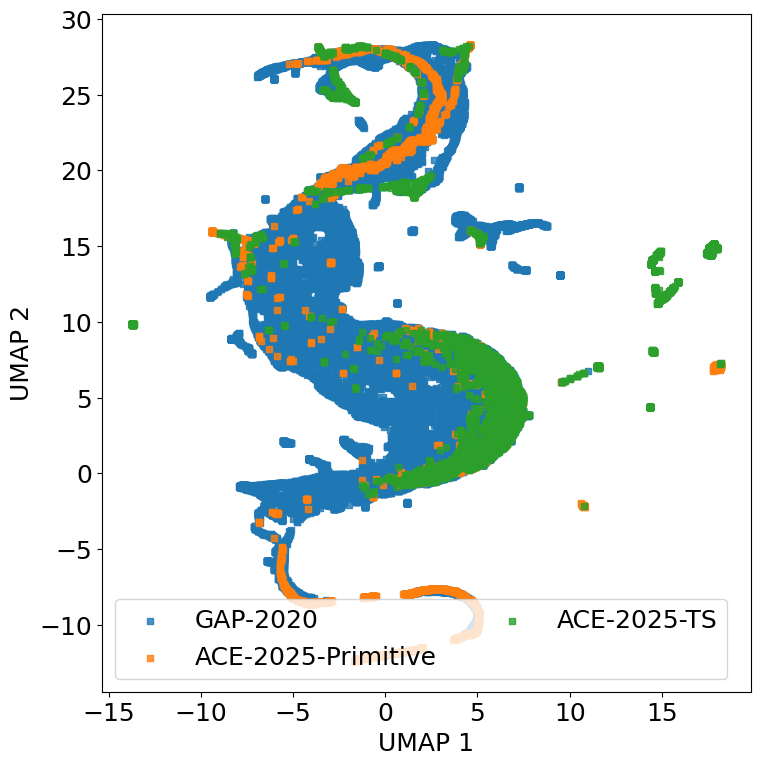

In [15]:
from umap import UMAP  # pip install umap-learn

DB_2020 = get_bbasis(configs_2020, W_bbasis_set)
DB_2025_primitive = get_bbasis(configs_2025[3927:6980], W_bbasis_set)
DB_2025_ts = get_bbasis(configs_2025[6980:], W_bbasis_set)

# ===== UMAP embedding =====
# stack all databases together so they share one UMAP space
X_all = np.vstack([DB_2020, DB_2025_primitive, DB_2025_ts])

umap = UMAP(
    n_components=2,
    n_neighbors=15,   # can tune
    min_dist=0.1,     # can tune
    random_state=0
)

embedding = umap.fit_transform(X_all)

# split back into the three parts
n0 = len(DB_2020)
n1 = len(DB_2025_primitive)
n2 = len(DB_2025_ts)

emb_2020        = embedding[:n0]
emb_2025_prim   = embedding[n0:n0 + n1]
emb_2025_ts     = embedding[n0 + n1:]

# ===== 2D Visualization of UMAP result =====
fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 18})
ax = fig.add_subplot()

db1_label = ['GAP-2020', 'ACE-2025-Primitive', 'ACE-2025-TS']
embeddings = [emb_2020, emb_2025_prim, emb_2025_ts]

for emb, label in zip(embeddings, db1_label):
    ax.scatter(emb[:, 0], emb[:, 1], marker='s', s=20, alpha=0.8, label=label)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.legend(ncol=2)

plt.tight_layout()
plt.savefig('compare_tungsten_umap.png', dpi=600)
